# Variational Autoencoder

In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


Using Theano backend.


In [25]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

In [40]:
''' define the specs BOI'''

batch_size = 1000
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 1.0


In [41]:
''' make the input and encoder layers'''

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


In [42]:
''' sampling stage '''

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [43]:
''' model architecture '''

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [44]:
''' define the cost function '''

def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [45]:
''' Compile the model now '''

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

### Training VAE

In [46]:
# train the VAE on MNIST digits -- for now we are using MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s - loss: 268.5380 - val_loss: 211.0970
Epoch 2/50
60000/60000 [==============================] - 4s - loss: 199.8022 - val_loss: 192.5315
Epoch 3/50
60000/60000 [==============================] - 4s - loss: 188.6872 - val_loss: 184.7637
Epoch 4/50
60000/60000 [==============================] - 4s - loss: 183.4836 - val_loss: 180.6405
Epoch 5/50
60000/60000 [==============================] - 4s - loss: 178.7786 - val_loss: 176.4668
Epoch 6/50
60000/60000 [==============================] - 4s - loss: 175.3391 - val_loss: 173.2881
Epoch 7/50
60000/60000 [==============================] - 4s - loss: 173.1641 - val_loss: 171.3173
Epoch 8/50
60000/60000 [==============================] - 4s - loss: 171.6220 - val_loss: 170.6607
Epoch 9/50
60000/60000 [==============================] - 4s - loss: 170.5301 - val_loss: 170.0617
Epoch 10/50
60000/60000 [==============================] - 

In [47]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

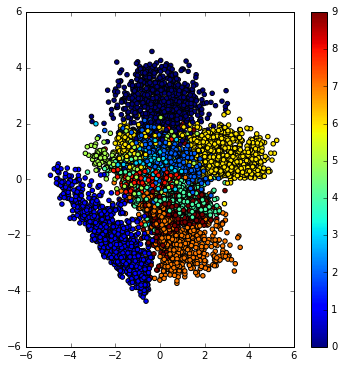

In [48]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [49]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

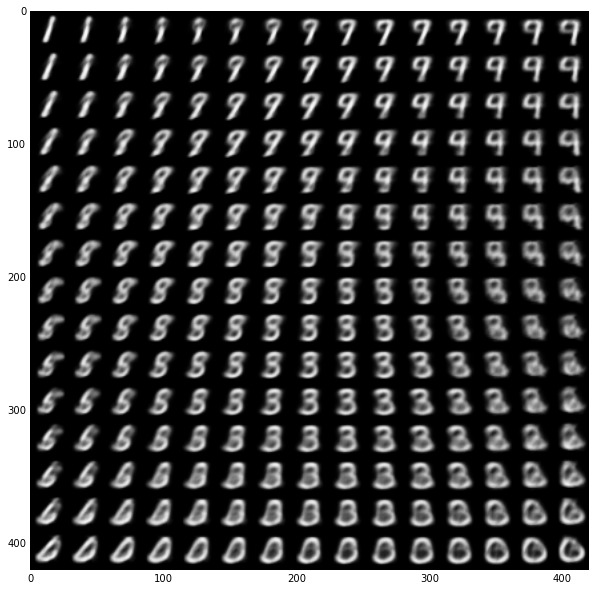

In [50]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()